In [124]:
from pathlib import Path

from fibrosisanalysis.slice import HeartSliceBuilder
from fibrosisanalysis.parsers import ImageLoader, StatsLoader, DensityLoader
from fibrosisanalysis.analysis import ObjectsPropertiesBuilder, SegmentsPropertiesBuilder

%matplotlib inline
path = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/data')
# path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')
path_stats = path

heart = 'E10927_MYBPC3'
slice_name = 'E10927_14_SC2'

n_radial = 3
n_angular = 12
node_step = 3

heart_slice_builder = HeartSliceBuilder()
heart_slice_builder.build_from_file(path, 
                                    heart, 
                                    slice_name,
                                    n_angular,
                                    n_radial, 
                                    node_step)
heart_slice = heart_slice_builder.heart_slice

# Load stats
path_slice_stats = path_stats.joinpath(heart, 'Stats', slice_name)
stats_loader = StatsLoader(path_stats)
object_stats = stats_loader.load_slice_data(path_slice_stats)

# Build objects properties
objects_props_builder = ObjectsPropertiesBuilder()
objects_props_builder.build_from_stats(object_stats)
objects_props_builder.add_slice_props(heart_slice)
objects_props = objects_props_builder.objects_props

# Build segment properties
segments_props_builder = SegmentsPropertiesBuilder()
segments_props_builder.build(heart_slice, objects_props)
props = segments_props_builder.props

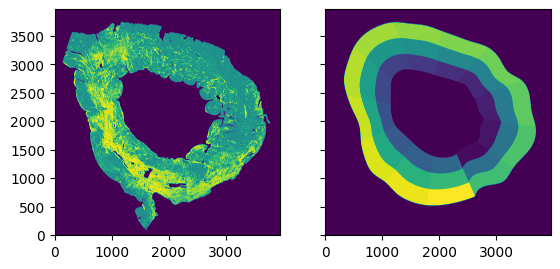

In [194]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
axs[0].imshow(heart_slice.image, origin='lower')
axs[1].imshow(heart_slice.total_segments, origin='lower')
plt.show()

In [195]:
props.head()

,segment_labels,centroid-0,centroid-1,edge_direction,structural_anisotropy,sa_orientation,sa_major_axis,sa_minor_axis,fibrosis,relative_orientation
0,1,1438.689585,2562.266738,0.970194,1.672571,1.195455,9.624900,5.754552,0.329711,-0.225262
1,2,1790.506782,2869.822481,0.396596,1.392613,0.967335,11.042361,7.929240,0.261577,-0.570739
2,3,2242.344805,2846.581048,-0.353172,1.343298,-2.441703,13.096334,9.749386,0.160469,-1.053062
3,4,2638.744883,2608.461579,-0.790553,1.465227,1.586931,11.757511,8.024360,0.181222,0.764109
4,5,2868.537258,2185.681893,-1.256312,1.750671,1.583066,11.124979,6.354693,0.199533,0.302214


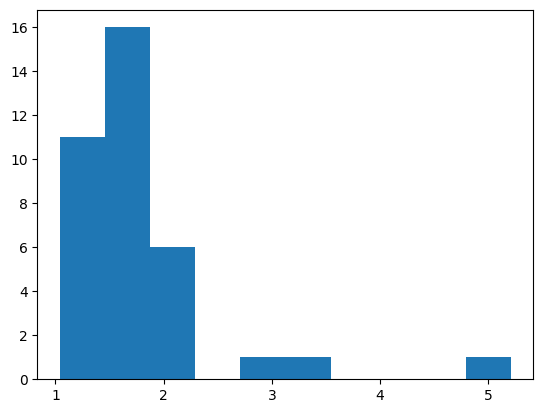

In [196]:
plt.hist(props['structural_anisotropy'].values)
plt.show()

In [197]:
props[['segment_labels', 'structural_anisotropy']]

,segment_labels,structural_anisotropy
0,1,1.672571
1,2,1.392613
2,3,1.343298
3,4,1.465227
4,5,1.750671
5,6,1.344083
6,7,1.274474
7,8,1.552379
8,9,1.462687
9,10,1.204668


In [238]:
import warnings
import numpy as np
from scipy import stats
from bitis.texture.properties.polar_plots import PolarPlots


class DistributionEllipse:
    def __init__(self):
        self.type_name = None
        self.width = None
        self.height = None
        self.orientation = None

    @property
    def anisotropy(self):
        return self.width / self.height

    @property
    def full_radius(self):
        r, _ = PolarPlots.rotated_ellipse(0.5 * self.width, 0.5 * self.height, 
                                          self.orientation, n=100)
        return r

    @property
    def full_theta(self):
        _, theta = PolarPlots.rotated_ellipse(0.5 * self.width,
                                              0.5 * self.height,
                                              self.orientation, n=100)
        return theta


class DistributionEllipseBuilder:
    def __init__(self):
        self.dist_ellipse = DistributionEllipse()
        # self.cov_estimator = MinCovDet()
        self.cov_estimator = EmpiricalCovariance()

    def build(self, r, theta, n_std=2., ellipse_type='error',
              min_samples=5):
        """Build a distribution ellipse from objects properties.

        Parameters
        ----------
        objects_props : ObjectsProperties
            Objects properties.
        n_std : float, optional
            Number of standard deviations.
        ellipse_type : str, optional
            Type of the ellipse ('error' or 'confidence').
        """
        if len(r) < 2 * min_samples:
            warnings.warn('Not enough samples to build the distribution ellipse.')

            self.dist_ellipse = DistributionEllipse()
            return self.dist_ellipse

        x, y = PolarPlots.polar_to_cartesian(r, theta)
        X = np.array([x, y]).T
        self.cov_estimator.fit(X)
        cov = self.cov_estimator.covariance_
        eig_vals, eig_vec = self.sorted_eigs(cov)

        if ellipse_type.lower() == 'error':
            width, height = self.error_ellipse(eig_vals, n_std)

        if ellipse_type.lower() == 'confidence':
            width, height = self.confidence_ellipse(eig_vals, n_std)

        theta = np.arctan2(* eig_vec[::-1, 0])
        # theta = np.arctan2(* eig_vec[:, 0])

        self.dist_ellipse = DistributionEllipse()
        self.dist_ellipse.type_name = ellipse_type
        self.dist_ellipse.width = width
        self.dist_ellipse.height = height
        self.dist_ellipse.orientation = theta
        return self.dist_ellipse

    def error_ellipse(self, eig_vals, n_std):
        """Calculate the width and height of an error ellipse.

        Parameters
        ----------
        eig_vals : np.ndarray
            Eigenvalues of the covariance matrix.
        n_std : float
            Number of standard deviations.

        Returns
        -------
        tuple
            Width and height of the error ellipse.
        """
        width, height = 2 * n_std * np.sqrt(eig_vals)
        return width, height

    def confidence_ellipse(self, eig_vals, n_std):
        """Calculate the width and height of a confidence ellipse.

        Parameters
        ----------
        eig_vals : np.ndarray
            Eigenvalues of the covariance matrix.
        n_std : float
            Number of standard deviations.

        Returns
        -------
        tuple
            Width and height of the confidence ellipse.
        """
        # Confidence level
        q = 2 * stats.norm.cdf(n_std) - 1
        r2 = stats.chi2.ppf(q, 2)
        width, height = 2 * np.sqrt(eig_vals * r2)
        return width, height

    def covariance(self, x, y):
        """Calculate the covariance matrix between two variables.

        Parameters
        ----------
        x : np.ndarray
            Input data for x-coordinate.
        y : np.ndarray
            Input data for y-coordinate.

        Returns
        -------
        np.ndarray
            Covariance matrix between x and y.
        """
        return np.cov(np.vstack([x, y]), rowvar=True)

    def sorted_eigs(self, cov):
        """Sort eigenvalues and eigenvectors in descending order.

        Parameters
        ----------
        cov : np.ndarray
            Covariance matrix.

        Returns
        -------
        tuple
            Sorted eigenvalues and eigenvectors.
        """
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]


In [237]:
import numpy as np
from skimage import morphology
from bitis.texture.properties import (
    PatternPropertiesBuilder,
    PolarPlots
)

%matplotlib qt

def swap_axis(angle):
    """
    Swap axis for polar plot.
    """
    return 0.5 * np.pi - angle


def draw_anisotropy(ax, objects_props, n_std=2):
    objects_props = objects_props[objects_props['area'] >= 10]

    r = objects_props['axis_ratio']
    theta = objects_props['orientation']
    
    dist_ellipse_builder = DistributionEllipseBuilder()
    dist_ellipse = dist_ellipse_builder.build(objects_props, n_std=n_std, ellipse_type='error')
    full_theta = swap_axis(dist_ellipse.full_theta)
    orientation = swap_axis(dist_ellipse.orientation)
    r, theta, d = PolarPlots.sort_by_density(objects_props['axis_ratio'],
                                             swap_axis(objects_props['orientation']))
    colors = d
    # theta = swap_axis(theta)
        
    ax.scatter(theta, r, c=colors, s=30, alpha=1, cmap='viridis')
    ax.plot(full_theta, dist_ellipse.full_radius, color='red')

    ax.quiver(0, 0, orientation, 0.5 * dist_ellipse.width,
              angles='xy', scale_units='xy', scale=1, color='red')
    ax.quiver(0, 0, 0.5 * np.pi + orientation,
              0.5 * dist_ellipse.height,
              angles='xy', scale_units='xy', scale=1, color='red')

segment_label = 17
seg_obj_props = objects_props[objects_props['segment_labels'] == segment_label]
seg_obj_props = seg_obj_props[seg_obj_props['area'] > 10]
# seg_obj_props = seg_obj_props[outliers[:len(outliers) // 2] == 1]

im = heart_slice.image.copy()
im[~(heart_slice.total_segments == segment_label)] = 0
im = morphology.remove_small_objects(im == 2, min_size=1)
coords = np.argwhere(heart_slice.total_segments == segment_label)
xy_min = np.min(coords, axis=0)
xy_max = np.max(coords, axis=0)

fig, axs = plt.subplot_mosaic([['im', 'sa']],
                              per_subplot_kw={('sa'): {'projection': 'polar'}})
axs['im'].imshow(im, origin='lower')
axs['im'].set_ylim([xy_min[0], xy_max[0]])
axs['im'].set_xlim([xy_min[1], xy_max[1]])
draw_anisotropy(axs['sa'], seg_obj_props, n_std=2)
plt.show()

qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [208]:
from sklearn import ensemble

r = np.concatenate([seg_obj_props['axis_ratio'].values,
                    seg_obj_props['axis_ratio'].values])
theta = np.concatenate([seg_obj_props['orientation'].values,
                        np.pi + seg_obj_props['orientation'].values])

X = np.array([r * np.cos(theta), r * np.sin(theta)]).T

classifier = ensemble.IsolationForest(contamination=0.05)
outliers = classifier.fit_predict(X)

r[outliers == -1]


array([16.86334052, 12.99891793,  8.56477453, 16.20714862, 13.39192881,
       11.55946754, 10.05081494, 17.54997445, 13.00860687, 16.33084081,
       20.62347816, 20.10579668, 16.86334052, 12.99891793, 16.20714862,
       13.39192881, 11.55946754, 10.05081494, 17.54997445, 13.00860687,
       16.33084081, 20.62347816, 20.10579668])

In [209]:
from sklearn.decomposition import PCA


r = np.concatenate([seg_obj_props['axis_ratio'].values,
                    seg_obj_props['axis_ratio'].values])
theta = np.concatenate([seg_obj_props['orientation'].values,
                        np.pi + seg_obj_props['orientation'].values])

# r = r[outliers == 1]
# theta = theta[outliers == 1]

X = np.array([r * np.cos(theta), r * np.sin(theta)]).T

model = PCA()
model.fit(X)
model.get_covariance()

array([[  6.72475382, -12.75581566],
       [-12.75581566,  31.28293271]])

In [210]:
np.cov(np.vstack([X[:, 0], X[:, 1]]), rowvar=True)

array([[  6.72475382, -12.75581566],
       [-12.75581566,  31.28293271]])

In [214]:
import matplotlib.pyplot as plt

from sklearn.covariance import EmpiricalCovariance, MinCovDet

# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print("MCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    )
)

MCD (Robust):
[[ 5.05572156 -9.41133901]
 [-9.41133901 20.52628189]]
MLE:
[[  6.71007095 -12.72796454]
 [-12.72796454  31.21462936]]


[[15.63713911 15.47875557 15.32047808 ...  3.89934652  3.93171978
   3.97056139]
 [15.47931832 15.32083114 15.16244895 ...  3.85166355  3.89045576
   3.93565753]
 [15.32160302 15.16301115 15.00452317 ...  3.81035018  3.85563474
   3.90723563]
 ...
 [ 3.89355447  3.84353398  3.79988958 ... 15.04473757 15.20325223
  15.36186995]
 [ 3.92359     3.87999516  3.84286177 ... 15.20263639 15.36104554
  15.51955885]
 [ 3.96010078  3.92288401  3.89217933 ... 15.36063885 15.51894356
  15.67735351]]


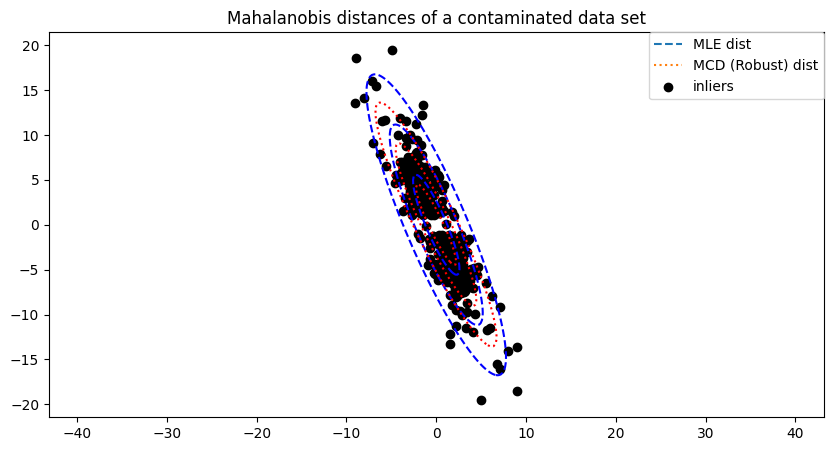

In [230]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(10, 5))
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color="black", label="inliers")
# Plot data set

# outlier_plot = ax.scatter(
#     X[:, 0][-n_outliers:], X[:, 1][-n_outliers:], color="red", label="outliers"
# )
ax.set_xlim(ax.get_xlim()[0], 10.0)
ax.set_title("Mahalanobis distances of a contaminated data set")

# Create meshgrid of feature 1 and feature 2 values
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)

mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)

print(np.sqrt(mahal_emp_cov))
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), linestyles="dashed",
    levels=np.arange(1, 4), colors='b'
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), linestyles="dotted",
    levels=np.arange(1, 4), colors='red'
)

# Add legend
ax.legend(
    [
        mlines.Line2D([], [], color="tab:blue", linestyle="dashed"),
        mlines.Line2D([], [], color="tab:orange", linestyle="dotted"),
        inlier_plot,
        # outlier_plot,
    ],
    ["MLE dist", "MCD (Robust) dist", "inliers"],
    loc="upper right",
    borderaxespad=0,
)
ax.axis('equal')
plt.show()